In [1]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from utils import featre_to_tick, get_colors_dict
import argparse
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import linkage, leaves_list
from matplotlib.colors import Normalize

def calculate_corr_matrix(df1, df2, method='spearman', pvalue_correction="fdr_bh"):
    if method not in ['spearman', 'pearson']:
        raise ValueError("Method must be 'spearman' or 'pearson'")
    
    # Drop rows with NaN values in Y and align the indices
    non_nan_indices = ~df2.isna().any(axis=1)
    df1 = df1.loc[non_nan_indices]
    df2 = df2.loc[non_nan_indices]

    # scaling the data
    scaler = MinMaxScaler()
    df1 = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns, index=df1.index)
    df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns, index=df2.index)

    corr_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    pvalue_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    for row in df1.columns:
        for col in df2.columns:
            if method == 'spearman':
                corr, pvalue = stats.spearmanr(df1[row], df2[col])
            elif method == 'pearson':
                corr, pvalue = stats.pearsonr(df1[row], df2[col])
            corr_matrix.at[row, col] = np.float32(corr)
            pvalue_matrix.at[row, col] = np.float32(pvalue)
    # correcting pvalues for the number of genes
    if pvalue_correction is not None:
        # Flatten the DataFrame to a 1D array
        pvals = pvalue_matrix.values.flatten()
        # Apply the correction
        corrected_pvals = multipletests(pvals, alpha=0.05, method=pvalue_correction)[1]
        # Reshape the corrected p-values back to the original shape of pvalue_matrix
        corrected_pvals_matrix = corrected_pvals.reshape(pvalue_matrix.shape)
        # Replace the values in the original DataFrame
        pvalue_matrix.loc[:, :] = corrected_pvals_matrix

    return corr_matrix, pvalue_matrix

save_root = "gene/cnv_corr"

# keep only columns that are related to mutations
gene_expr_all = pd.read_csv("gene/data/PORPOISE_data_matched.csv")
sel_cols = [col for col in gene_expr_all.columns if "_cnv" in col]
gene_expr_all = gene_expr_all[['type', 'case_id', 'slide_id'] + sel_cols]

col_rename_dict = {col: col.split("_")[0] for col in sel_cols}
gene_expr_all = gene_expr_all.rename(columns=col_rename_dict)


selected_feats = [
"mit_wsi_count",
"mit_hotspot_count",
"mit_nodeDegrees_mean",
"mit_nodeDegrees_max",
"mit_nodeDegrees_std",
"mit_clusterCoff_mean",
"mit_clusterCoff_std",
"mit_clusterCoff_perc10",
"mit_clusterCoff_perc80",
"mit_cenDegree_mean",
"mit_cenDegree_std",
"mit_cenCloseness_max",
"mit_cenEigen_mean",
"mit_cenEigen_max",
"mit_cenEigen_std",
"mit_cenHarmonic_mean",
"mit_cenHarmonic_std",
]
mitosis_feats = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv')
mitosis_feats = mitosis_feats[["bcr_patient_barcode", "type"]+selected_feats]
mitosis_feats.columns = [featre_to_tick(col) if col not in ["bcr_patient_barcode", "type"] else col for col in mitosis_feats.columns]
mitosis_feats["type"] = mitosis_feats["type"].replace(["COAD", "READ"], "COADREAD")



/tmp/ipykernel_3396335/2879338009.py:59: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_expr_all = pd.read_csv("gene/data/PORPOISE_data_matched.csv")


Working on STAD


/tmp/ipykernel_3396335/149484212.py:83: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = pval_matrix_reordered.applymap(lambda x: '*' if x < 0.05 else '')
/tmp/ipykernel_3396335/149484212.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dot_data['size'][dot_data['size']>pval_max]=pval_max
/home/u2070124/miniconda3/envs/tiaviz/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tmp/ipykernel_3396335/149484212.py:178: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dotplot.set_xticklabels(ax_dotplot.get_xticklabels(), rotation=90)
/tmp/ipykernel_339633

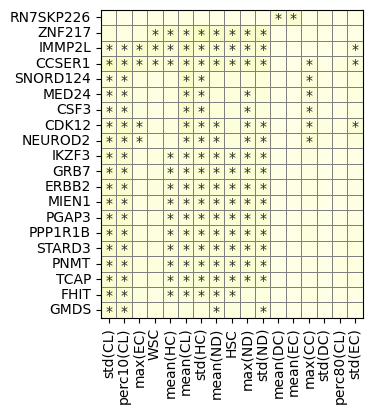

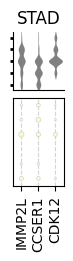

In [115]:
def calculate_annova_matrix(X, Y):
    # Drop rows with NaN values in Y and align the indices
    non_nan_indices = ~Y.isna().any(axis=1)
    X = X.loc[non_nan_indices]
    Y = Y.loc[non_nan_indices]
    
    # Initialize an empty DataFrame for the AUC association matrix
    f_matrix = pd.DataFrame(index=X.columns, columns=Y.columns)
    p_matrix = pd.DataFrame(index=X.columns, columns=Y.columns)
    
    # Iterate over each combination of columns from X and Y
    for x_col in X.columns:
        for y_col in Y.columns:
            data = {
                'phenotype': X[x_col].to_list(),
                'CNV':       Y[y_col].to_list()
            }
            df = pd.DataFrame(data)
            # Group data by CNV levels
            groups = df.groupby('CNV')['phenotype'].apply(list)
            # Perform one-way ANOVA
            f_statistic, p_value = stats.f_oneway(*groups)
            f_matrix.at[x_col, y_col] = f_statistic
            p_matrix.at[x_col, y_col] = p_value
    return f_matrix.astype(float), p_matrix.astype(float)

for ci, cancer_type in enumerate(["STAD"]): # enumerate(sorted(gene_expr_all["type"].unique())[3:]):
    ci=1
    print(f"Working on {cancer_type}")

    mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"]==cancer_type]
    gene_exp_cancer = gene_expr_all[gene_expr_all["type"]==cancer_type]

    # drop missing mutations
    gene_exp_cancer = gene_exp_cancer.dropna(axis=1, how="all")

    # Find the common case names between mitosis features and gene expressions
    common_cases = pd.Series(list(set(mitosis_feats_cancer['bcr_patient_barcode']).intersection(set(gene_exp_cancer['case_id']))))
    ## Keep only the rows with the common case names in both dataframes
    df1_common = mitosis_feats_cancer[mitosis_feats_cancer['bcr_patient_barcode'].isin(common_cases)]
    df2_common = gene_exp_cancer[gene_exp_cancer['case_id'].isin(common_cases)]
    df2_common = df2_common.drop_duplicates(subset='case_id')

    ## Sort the dataframes based on 'case_name'
    df1_common = df1_common.sort_values('bcr_patient_barcode')
    df2_common = df2_common.sort_values('case_id')

    X = df1_common.drop(columns=["bcr_patient_barcode", "type"]).reset_index(drop=True)
    Y = df2_common.drop(columns=['case_id', 'type', 'slide_id']).reset_index(drop=True)

    X = X[X.std(axis=0).index[X.std(axis=0)!=0]]

    if len(X)==0 or len(Y)==0:
        print("Not enough samples to process")
        continue


    # Measure feature-mutation association
    corr_matrix, pval_matrix = calculate_annova_matrix(X, Y)

    auc_matrix = corr_matrix.T
    pval_matrix = pval_matrix.T
    if len(auc_matrix) > 20:
        aucs_sorted = auc_matrix.abs().max(axis=1).sort_values(ascending=False)
        max_ass = aucs_sorted.head(20).index
        auc_matrix = auc_matrix.loc[list(max_ass), :]
        pval_matrix = pval_matrix.loc[list(max_ass), :]
    
    # Perform hierarchical clustering
    row_linkage = linkage(auc_matrix, method='ward')
    col_linkage = linkage(auc_matrix.T, method='ward')

    # Get the order of rows and columns based on clustering
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)

    # Reorder the data matrix
    auc_matrix_reordered = auc_matrix.iloc[:, col_order].iloc[row_order, :]
    pval_matrix_reordered = pval_matrix.iloc[:, col_order].iloc[row_order, :]

    # Plot the heatmap with reordered data and customization
    plt.figure(figsize=(4, 4))
    annotations = pval_matrix_reordered.applymap(lambda x: '*' if x < 0.05 else '')
    heatmap = sns.heatmap(auc_matrix_reordered, cmap="YlGn", vmin=1, vmax=50, cbar=False, 
                        linewidths=0.5, linecolor='gray', square=True,
                        annot=annotations, fmt='', annot_kws={"size": 10, "va": "center_baseline", "ha": "center"},
                        cbar_kws={'shrink': 0.5, 'label': 'Scaled AUC'})


    for _, spine in heatmap.spines.items():
        spine.set_visible(True)

    # plt.savefig(save_dir+f"cnv_corr_{cancer_type}_top20.pdf", dpi=300, bbox_inches = 'tight', pad_inches = 0)


    # plot max-top 5
    top_n = 5
    auc_matrix_reordered = auc_matrix_reordered[["max(EC)","mean(HC)", "mean(DC)",  "mean(CL)", "mean(ND)", "HSC"]] 
    pval_matrix_reordered = pval_matrix_reordered[["max(EC)", "mean(HC)", "mean(DC)", "mean(CL)", "mean(ND)", "HSC"]] 

    if len(auc_matrix_reordered) > top_n:
        max_ass = auc_matrix_reordered.abs().max(axis=1).sort_values(ascending=False)
        if len(max_ass[max_ass>5]) > 5:
            max_ass = max_ass.head(5).index
        elif len(max_ass[max_ass>5]) < 3:
            max_ass = max_ass.head(2).index
        else:
            max_ass = max_ass[max_ass>5].index    
        auc_matrix_reordered = auc_matrix_reordered.loc[list(max_ass), :]
        pval_matrix_reordered = pval_matrix_reordered.loc[list(max_ass), :]

    # Plotting violin plot and dotpolot 
    n_cols = auc_matrix_reordered.shape[0]
    cell_size = 0.22  # size of each cell in inches
    fig_width = n_cols * cell_size
    fig_height = 2  # adjusted height for the inclusion of violin plot

    # Create a violin plot above the heatmap
    fig, (ax_violin, ax_dotplot) = plt.subplots(2, 1, figsize=(fig_width, fig_height), 
                                                gridspec_kw={'height_ratios': [1, 1.5], 'hspace': 0.1})

    # Prepare data for violin plot
    Y_selected = Y[auc_matrix_reordered.index].melt(var_name='Variable', value_name='CNV')

    # Violin plot
    sns.violinplot(x='Variable', y='CNV', data=Y_selected, ax=ax_violin, inner=None, linewidth=0.1, color="gray")
    ax_violin.set_xticklabels([])
    ax_violin.set_xticks([])
    ax_violin.set_xlabel('')
    ax_violin.set_ylabel('' if ci!=0 else 'CNV')
    ax_violin.set_title(cancer_type)  # example title, adjust as needed
    ax_violin.spines['top'].set_visible(False)
    ax_violin.spines['right'].set_visible(False)
    ax_violin.spines['left'].set_visible(True)
    ax_violin.spines['bottom'].set_visible(True)
    ax_violin.set_ylim(-2.5, 2.5)
    ax_violin.set_yticks([-2, -1, 0, 1, 2])
    ax_violin.tick_params(axis='y', length=2, width=2) 
    ax_violin.set_yticklabels([-2, -1, 0, 1, 2] if ci==0 else [])


    # Prepare data for dot plot
    auc_values = auc_matrix_reordered.values.flatten()
    pval_values = pval_matrix_reordered.values.flatten()
    y_labels = np.tile(auc_matrix_reordered.columns, auc_matrix_reordered.shape[0])
    x_labels = np.repeat(auc_matrix_reordered.index, auc_matrix_reordered.shape[1])

    # Normalize the AUC values for coloring
    norm = Normalize(vmin=1, vmax=50)
    cmap = plt.cm.YlGn
    colors = cmap(norm(auc_values))

    # Dot plot
    dot_data = pd.DataFrame({
        'x': x_labels,
        'y': y_labels,
        'auc': auc_values,
        'pval': pval_values,
    })
    dot_data['size'] = -np.log10(dot_data['pval'])

    # Normalize sizes between a specified range
    size_min, size_max = 10, 150  # Example size range
    pval_min, pval_max = 3, 30 
    dot_data['size'][dot_data['size']>pval_max]=pval_max
    sizes = (dot_data['size'] - pval_min) / (pval_max - pval_min) * (size_max - size_min) + size_min


    # Plotting the dot plot
    scatter = ax_dotplot.scatter(
        x=dot_data['x'], y=dot_data['y'], 
        c=colors, s=sizes,  # Adjust size scaling as needed
        edgecolor='lightgray', linewidth=0.5
    )

    # Customizing the dot plot
    ax_dotplot.invert_yaxis()
    ax_dotplot.set_xticklabels(ax_dotplot.get_xticklabels(), rotation=90)
    ax_dotplot.set_xlabel('')
    ax_dotplot.set_ylabel('')
    ax_dotplot.grid(color='lightgray', linestyle='dashed')
    ax_dotplot.set_axisbelow(True)
    ax_dotplot.set_ylim(-0.5, len(auc_matrix_reordered.columns)-0.5)
    ax_dotplot.set_xlim(-0.5, len(auc_matrix_reordered.index)-.5)
    if ci != 0:
        plt.yticks([])

    plt.tight_layout()
    # fig.savefig(save_dir+f"cnv_corr_{cancer_type}_top5.pdf", dpi=300, bbox_inches = 'tight', pad_inches = 0)
    # fig.savefig(save_dir+f"cnv_corr_{cancer_type}_top5.png", dpi=600, bbox_inches = 'tight', pad_inches = 0)
    fig.savefig("mosi_0.01_pad.png", dpi=300, bbox_inches = 'tight', pad_inches = 0.01, transparent=True)


In [ ]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for i in range(len(dot_data[dot_data["pval"]<0.01])):
    fig_size = (1.8, 2) if i==0 else (1.5, 2)
    sig = dot_data.iloc[i]
    # Tukey's HSD test
    tukey = pairwise_tukeyhsd(endog=X[sig["y"]], groups=Y[sig["x"]], alpha=0.01)
    results_as_html = tukey.summary().as_html()
    results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    results_df.to_csv("mosi.csv")

    fig, ax = plt.subplots(figsize=fig_size)
    _ = tukey.plot_simultaneous(figsize=fig_size, ax=ax, comparison_name=0., xlabel=sig["y"])
    ax.set_title(sig["x"])
    if i != 0:
        ax.set_yticklabels([])

    plt.tight_layout()
    fig.savefig("mosi.pdf", dpi=300, bbox_inches = 'tight', pad_inches = 0)

In [105]:
-np.log10(0.01)

2.0

/tmp/ipykernel_3396335/3794893674.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
/tmp/ipykernel_3396335/3794893674.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
/tmp/ipykernel_3396335/3794893674.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
/tmp/ipykernel_3396335/3794893674.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read fr

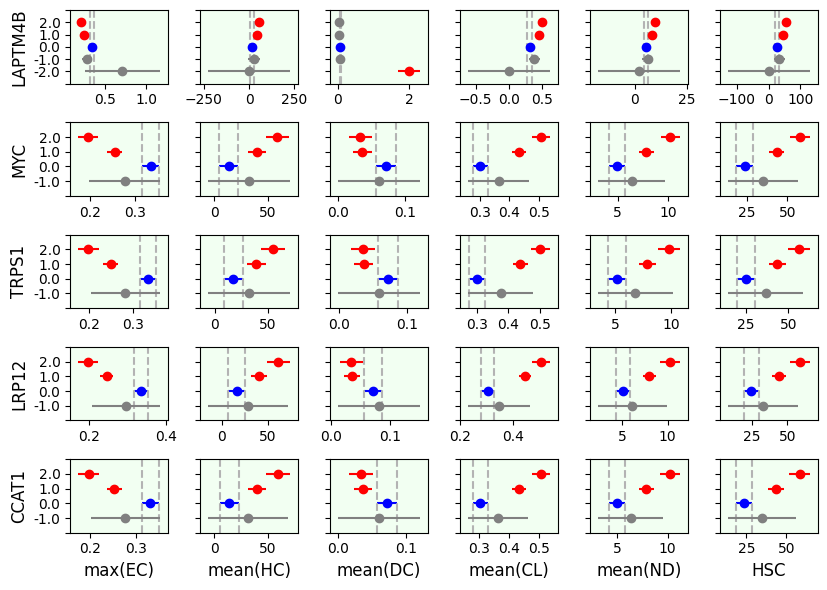

In [101]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import pandas as pd

# Assuming dot_data is already defined and contains 'x', 'y', and 'pval' columns
significant_data = dot_data[dot_data["pval"] < 0.01]

# Get unique values for x and y
unique_x = dot_data["x"].unique()
unique_y = dot_data["y"].unique()

# Create a figure with a 5x5 grid of subplots
fig_height = 6*len(unique_x)/5
fig_width = 7*len(unique_y)/5
fig, axes = plt.subplots(nrows=len(unique_x), ncols=len(unique_y), figsize=(2, 1))

# Loop over all possible combinations of unique x and y values
for x in unique_x:
    for y in unique_y:
        x_idx = list(unique_x).index(x)
        y_idx = list(unique_y).index(y)
        ax = axes[x_idx, y_idx]
        
        # Check if the combination is significant
        if not dot_data[(dot_data["x"] == x) & (dot_data["y"] == y) & (dot_data["pval"] < 0.01)].empty:
            significant = True
        else:
            significant = False
        
        # Set background color based on significance with transparency
        if significant:
            ax.set_facecolor((0.5, 1.0, 0.5, 0.1))  # lightgreen with alpha 0.3
        else:
            ax.set_facecolor((1.0, 0.5, 0.5, 0.1))  # lightcoral with alpha 0.3

        # Perform Tukey's HSD test and plot results
        tukey = pairwise_tukeyhsd(endog=X[y], groups=Y[x], alpha=0.01)
        _ = tukey.plot_simultaneous(ax=ax, figsize=(fig_width,fig_height), comparison_name=0., xlabel=y)

        results_as_html = tukey.summary().as_html()
        results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
        # results_df.to_csv(save_dir_tukey+f"tuckey_{sig["y"]}_{sig["x"]}.csv")

        
        ax.set_title('')
        if y_idx != 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(x, fontsize=12)
        
        if x_idx == len(unique_x)-1:
            ax.set_xlabel(y, fontsize=12)
        else:
            ax.set_xlabel('')

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=-1, hspace=-1)
plt.tight_layout()
# fig.savefig(save_dir_tukey+f"tuckey_{sig["y"]}_{sig["x"]}.pdf", dpi=300, bbox_inches = 'tight', pad_inches = 0)


In [ ]:
fig_height